# Projet Classification Vaccination

## Introduction

Pr√©dire la probabilit√© qu'une personne ait re√ßu ou non les vaccins contre la grippe H1N1 et la grippe saisonni√®re. Il y aura deux variables cibles (binaires : oui/non), ce qui correspond √† un probl√®me de classification supervis√©e.

Tu dois pr√©dire la probabilit√© qu'une personne ait re√ßu ou non les vaccins contre la grippe H1N1 et la grippe saisonni√®re. Tu auras deux variables cibles (binaires : oui/non), ce qui correspond √† un probl√®me de classification supervis√©e.

## 1. Importation des biblioth√®ques et chargement des donn√©es

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve
from sklearn.multioutput import MultiOutputClassifier
import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Chargement des donn√©es
X = pd.read_csv("sup/X.csv")
y = pd.read_csv("sup/y.csv")

print("Dimensions des donn√©es :")
print(f"X : {X.shape}")
print(f"y : {y.shape}")

Dimensions des donn√©es :
X : (26707, 36)
y : (26707, 3)


## 2. Pr√©paration compl√®te des donn√©es

### 2.1 Pr√©sentation des donn√©es (variables, dimensions, types)


Aper√ßu des features :
   respondent_id  h1n1_concern  h1n1_knowledge  behavioral_antiviral_meds  \
0              0           1.0             0.0                        0.0   
1              1           3.0             2.0                        0.0   
2              2           1.0             1.0                        0.0   
3              3           1.0             1.0                        0.0   
4              4           2.0             1.0                        0.0   

   behavioral_avoidance  behavioral_face_mask  behavioral_wash_hands  \
0                   0.0                   0.0                    0.0   
1                   1.0                   0.0                    1.0   
2                   1.0                   0.0                    0.0   
3                   1.0                   0.0                    1.0   
4                   1.0                   0.0                    1.0   

   behavioral_large_gatherings  behavioral_outside_home  \
0                    

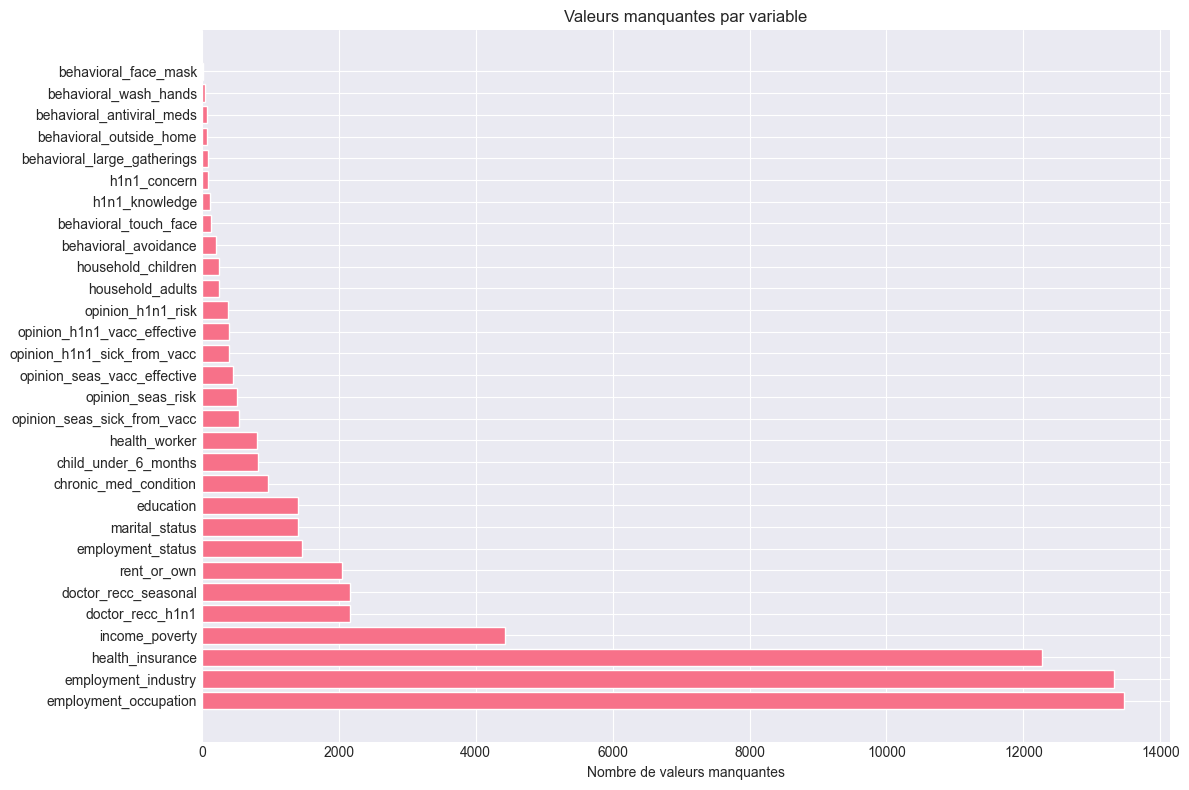

In [3]:
# Affichage des premi√®res lignes
print("\nAper√ßu des features :")
print(X.head())
print("\nAper√ßu des targets :")
print(y.head())

# Types de donn√©es
print("\nTypes de variables dans X :")
print(X.dtypes.value_counts())

# S√©paration des variables num√©riques et cat√©gorielles
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_features.remove('respondent_id')  # Retirer l'ID
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"\nNombre de variables num√©riques : {len(numerical_features)}")
print(f"Nombre de variables cat√©gorielles : {len(categorical_features)}")

# Description des variables cibles
print("\nDistribution des variables cibles :")
print("H1N1 vaccine :")
print(y['h1n1_vaccine'].value_counts(normalize=True))
print("\nSeasonal vaccine :")
print(y['seasonal_vaccine'].value_counts(normalize=True))

# Analyse des valeurs manquantes
missing_values = X.isnull().sum()
missing_percentage = (missing_values / len(X)) * 100
missing_df = pd.DataFrame({
    'Variable': missing_values.index,
    'Missing_Count': missing_values.values,
    'Percentage': missing_percentage.values
}).sort_values('Percentage', ascending=False)

print("\nTop 10 variables avec le plus de valeurs manquantes :")
print(missing_df.head(10))

# Visualisation des valeurs manquantes
plt.figure(figsize=(12, 8))
missing_data = X.isnull().sum()[X.isnull().sum() > 0].sort_values(ascending=False)
plt.barh(missing_data.index, missing_data.values)
plt.xlabel('Nombre de valeurs manquantes')
plt.title('Valeurs manquantes par variable')
plt.tight_layout()
plt.show()

### 2.2 Traitement des valeurs manquantes

In [4]:
# Strat√©gie de traitement :
# - Variables num√©riques : imputation par la m√©diane
# - Variables cat√©gorielles : imputation par le mode

# Cr√©ation des imputeurs
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

# Application de l'imputation
X_num_imputed = pd.DataFrame(
    num_imputer.fit_transform(X[numerical_features]),
    columns=numerical_features,
    index=X.index
)

X_cat_imputed = pd.DataFrame(
    cat_imputer.fit_transform(X[categorical_features]),
    columns=categorical_features,
    index=X.index
)

# Reconstitution du dataframe
X_imputed = pd.concat([X[['respondent_id']], X_num_imputed, X_cat_imputed], axis=1)

print("V√©rification : nombre de valeurs manquantes apr√®s imputation :", X_imputed.isnull().sum().sum())

V√©rification : nombre de valeurs manquantes apr√®s imputation : 0


### 2.3 Gestion des valeurs aberrantes

In [5]:
# D√©tection des outliers pour les variables num√©riques avec IQR
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return len(outliers), lower_bound, upper_bound

# Analyse des outliers pour household_adults et household_children
for col in ['household_adults', 'household_children']:
    n_outliers, lb, ub = detect_outliers_iqr(X_imputed, col)
    print(f"\n{col}: {n_outliers} outliers d√©tect√©s")
    print(f"Limites: [{lb:.2f}, {ub:.2f}]")
    print(f"Valeurs uniques: {sorted(X_imputed[col].unique())}")

# Note: Les variables household sont top-coded √† 3, donc pas de traitement n√©cessaire


household_adults: 1125 outliers d√©tect√©s
Limites: [-1.50, 2.50]
Valeurs uniques: [0.0, 1.0, 2.0, 3.0]

household_children: 1747 outliers d√©tect√©s
Limites: [-1.50, 2.50]
Valeurs uniques: [0.0, 1.0, 2.0, 3.0]


### 2.4 S√©lection pertinente des variables (Feature selection)


Top 10 corr√©lations avec h1n1_vaccine :
h1n1_vaccine                   1.000000
doctor_recc_h1n1               0.394086
seasonal_vaccine               0.377143
opinion_h1n1_risk              0.320580
opinion_h1n1_vacc_effective    0.267352
opinion_seas_risk              0.255874
doctor_recc_seasonal           0.218976
opinion_seas_vacc_effective    0.177799
health_worker                  0.168056
h1n1_concern                   0.121574
Name: h1n1_vaccine, dtype: float64


<Figure size 1000x1200 with 0 Axes>

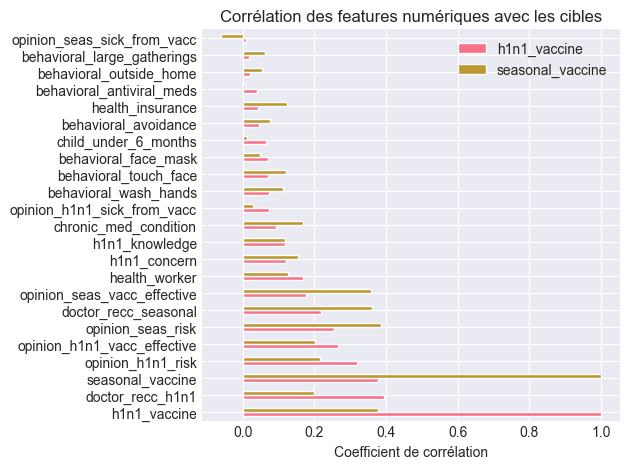

In [6]:
# Analyse de corr√©lation avec les cibles
# Fusion temporaire pour l'analyse
data_for_correlation = pd.concat([X_imputed[numerical_features], y[['h1n1_vaccine', 'seasonal_vaccine']]], axis=1)
correlation_with_targets = data_for_correlation.corr()[['h1n1_vaccine', 'seasonal_vaccine']].sort_values('h1n1_vaccine', ascending=False)

print("\nTop 10 corr√©lations avec h1n1_vaccine :")
print(correlation_with_targets['h1n1_vaccine'].head(10))

# Visualisation des corr√©lations importantes
plt.figure(figsize=(10, 12))
correlation_with_targets[:-2].plot(kind='barh')
plt.title('Corr√©lation des features num√©riques avec les cibles')
plt.xlabel('Coefficient de corr√©lation')
plt.tight_layout()
plt.show()

# Variables importantes identifi√©es :
important_features = [
    'doctor_recc_h1n1', 'doctor_recc_seasonal', 'health_insurance',
    'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'opinion_seas_vacc_effective',
    'h1n1_concern', 'h1n1_knowledge', 'health_worker', 'age_group', 'education'
]


### 2.5 Normalisation et transformation des variables

In [7]:
# Pr√©paration du pipeline de preprocessing
# Variables num√©riques
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Variables cat√©gorielles
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

# ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

## 3. Analyse exploratoire approfondie

### 3.1 Visualisations des variables qualitatives


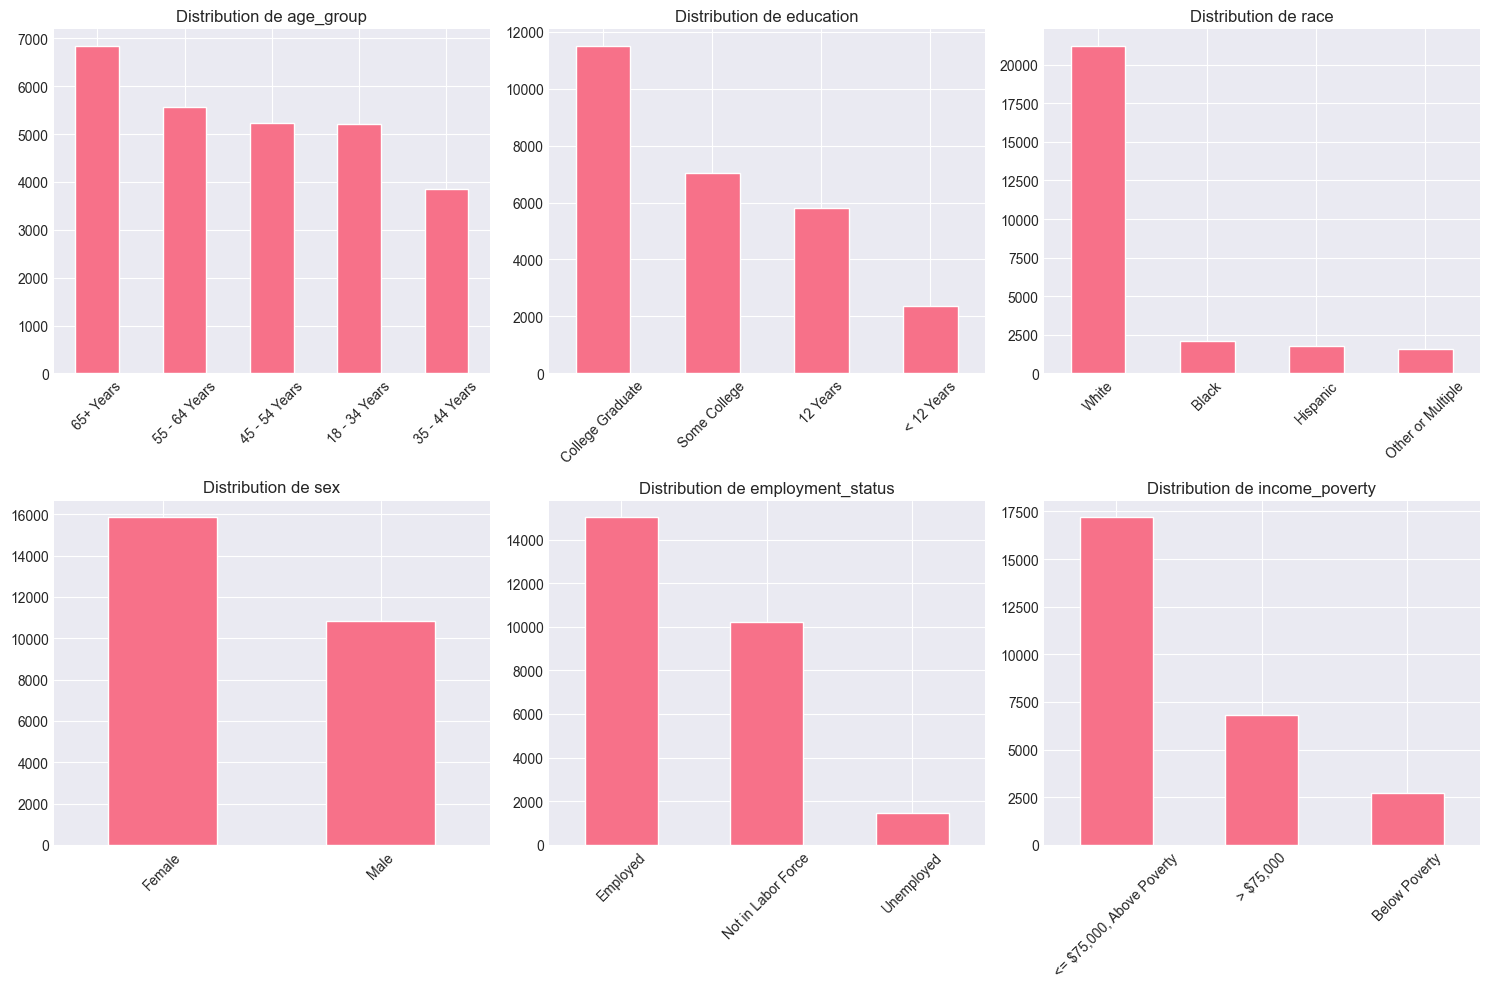

In [8]:
# Distribution des variables cat√©gorielles importantes
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

important_cat_vars = ['age_group', 'education', 'race', 'sex', 'employment_status', 'income_poverty']

for idx, var in enumerate(important_cat_vars):
    X_imputed[var].value_counts().plot(kind='bar', ax=axes[idx])
    axes[idx].set_title(f'Distribution de {var}')
    axes[idx].set_xlabel('')
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### 3.2 Visualisations des variables quantitatives

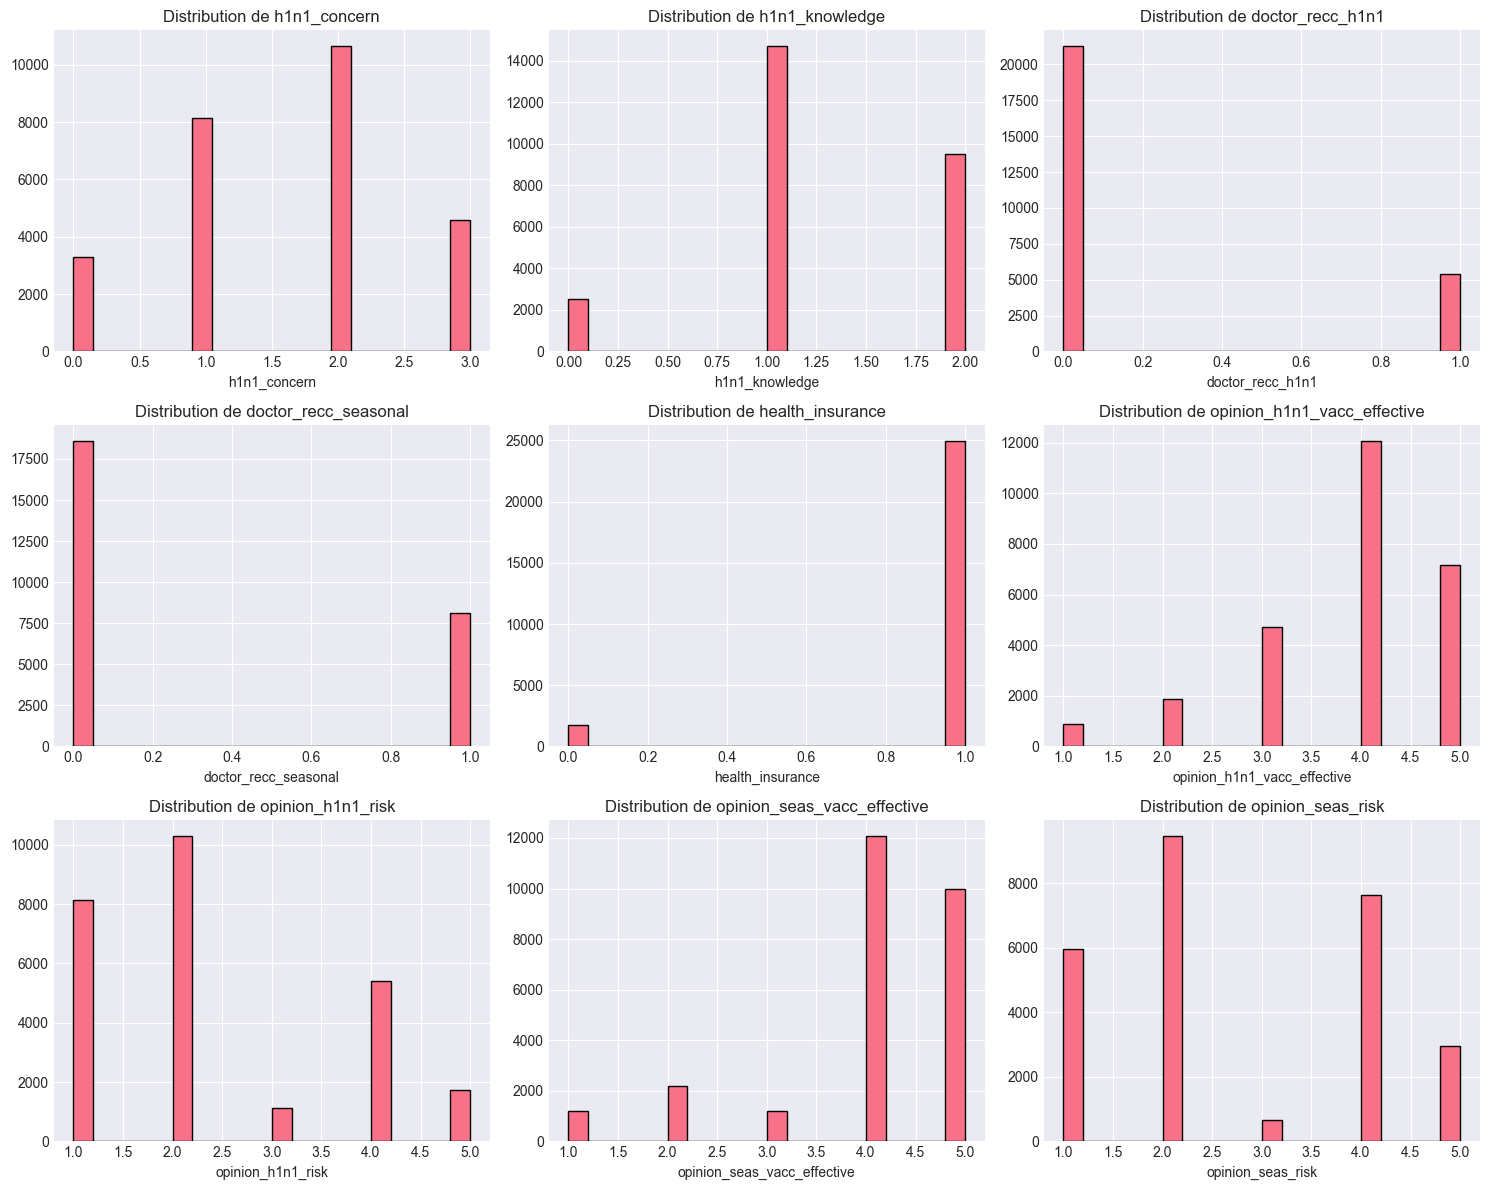

In [9]:
# Distribution des variables num√©riques importantes
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

important_num_vars = [
    'h1n1_concern', 'h1n1_knowledge', 'doctor_recc_h1n1',
    'doctor_recc_seasonal', 'health_insurance', 'opinion_h1n1_vacc_effective',
    'opinion_h1n1_risk', 'opinion_seas_vacc_effective', 'opinion_seas_risk'
]

for idx, var in enumerate(important_num_vars):
    X_imputed[var].hist(ax=axes[idx], bins=20, edgecolor='black')
    axes[idx].set_title(f'Distribution de {var}')
    axes[idx].set_xlabel(var)

plt.tight_layout()
plt.show()

### 3.3 Visualisations crois√©es (quali x quanti)

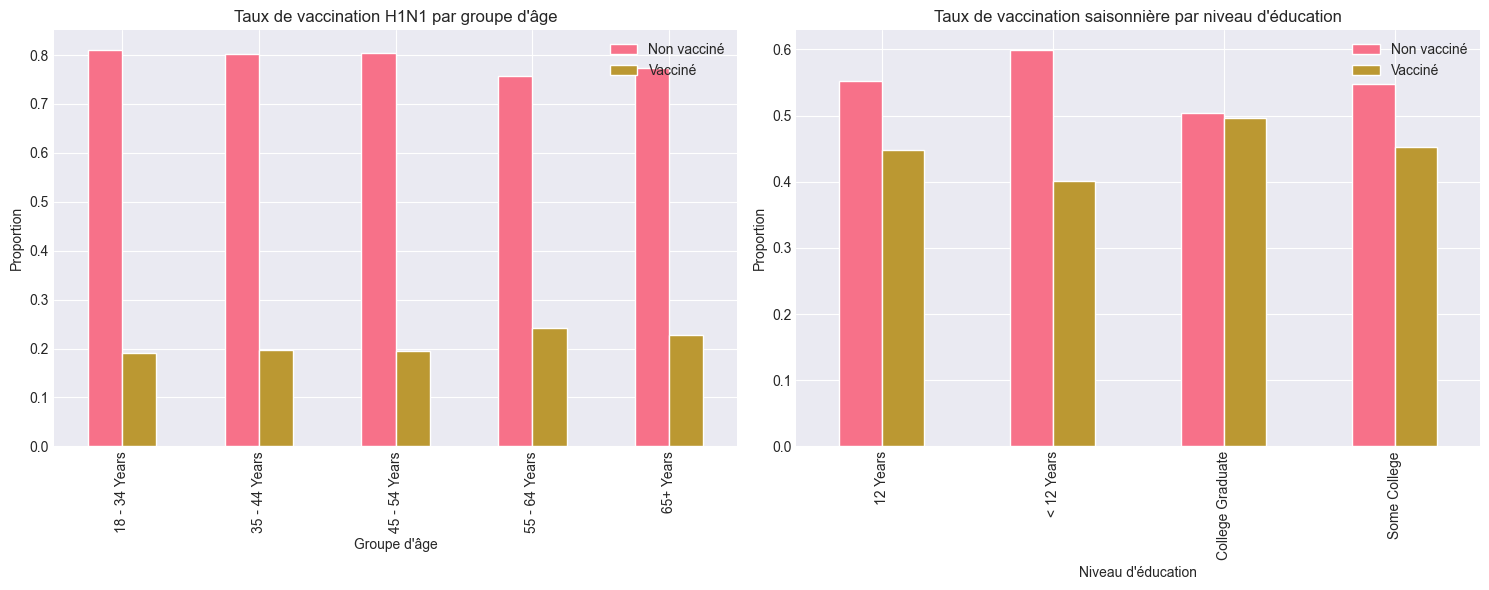

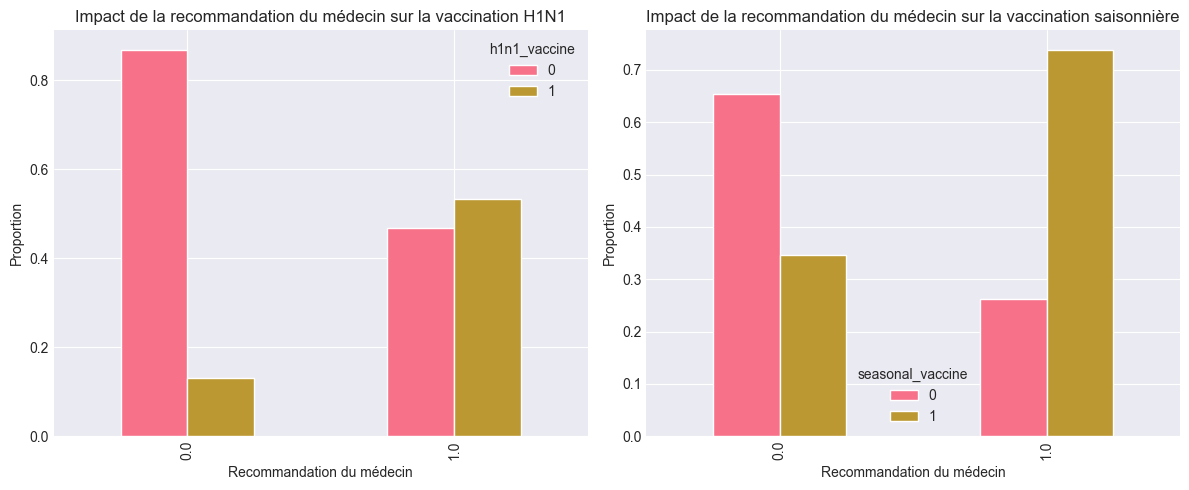

In [10]:
# Analyse de la vaccination selon l'√¢ge et le sexe
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# H1N1 vaccination par groupe d'√¢ge
vaccine_by_age = pd.crosstab(X_imputed['age_group'], y['h1n1_vaccine'], normalize='index')
vaccine_by_age.plot(kind='bar', ax=ax1)
ax1.set_title('Taux de vaccination H1N1 par groupe d\'√¢ge')
ax1.set_xlabel('Groupe d\'√¢ge')
ax1.set_ylabel('Proportion')
ax1.legend(['Non vaccin√©', 'Vaccin√©'])

# Vaccination saisonni√®re par niveau d'√©ducation
vaccine_by_edu = pd.crosstab(X_imputed['education'], y['seasonal_vaccine'], normalize='index')
vaccine_by_edu.plot(kind='bar', ax=ax2)
ax2.set_title('Taux de vaccination saisonni√®re par niveau d\'√©ducation')
ax2.set_xlabel('Niveau d\'√©ducation')
ax2.set_ylabel('Proportion')
ax2.legend(['Non vaccin√©', 'Vaccin√©'])

plt.tight_layout()
plt.show()

# Analyse de l'impact de la recommandation du m√©decin
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# H1N1
pd.crosstab(X_imputed['doctor_recc_h1n1'], y['h1n1_vaccine'], normalize='index').plot(
    kind='bar', ax=ax1
)
ax1.set_title('Impact de la recommandation du m√©decin sur la vaccination H1N1')
ax1.set_xlabel('Recommandation du m√©decin')
ax1.set_ylabel('Proportion')

# Saisonni√®re
pd.crosstab(X_imputed['doctor_recc_seasonal'], y['seasonal_vaccine'], normalize='index').plot(
    kind='bar', ax=ax2
)
ax2.set_title('Impact de la recommandation du m√©decin sur la vaccination saisonni√®re')
ax2.set_xlabel('Recommandation du m√©decin')
ax2.set_ylabel('Proportion')

plt.tight_layout()
plt.show()

### 3.4 Table de corr√©lation

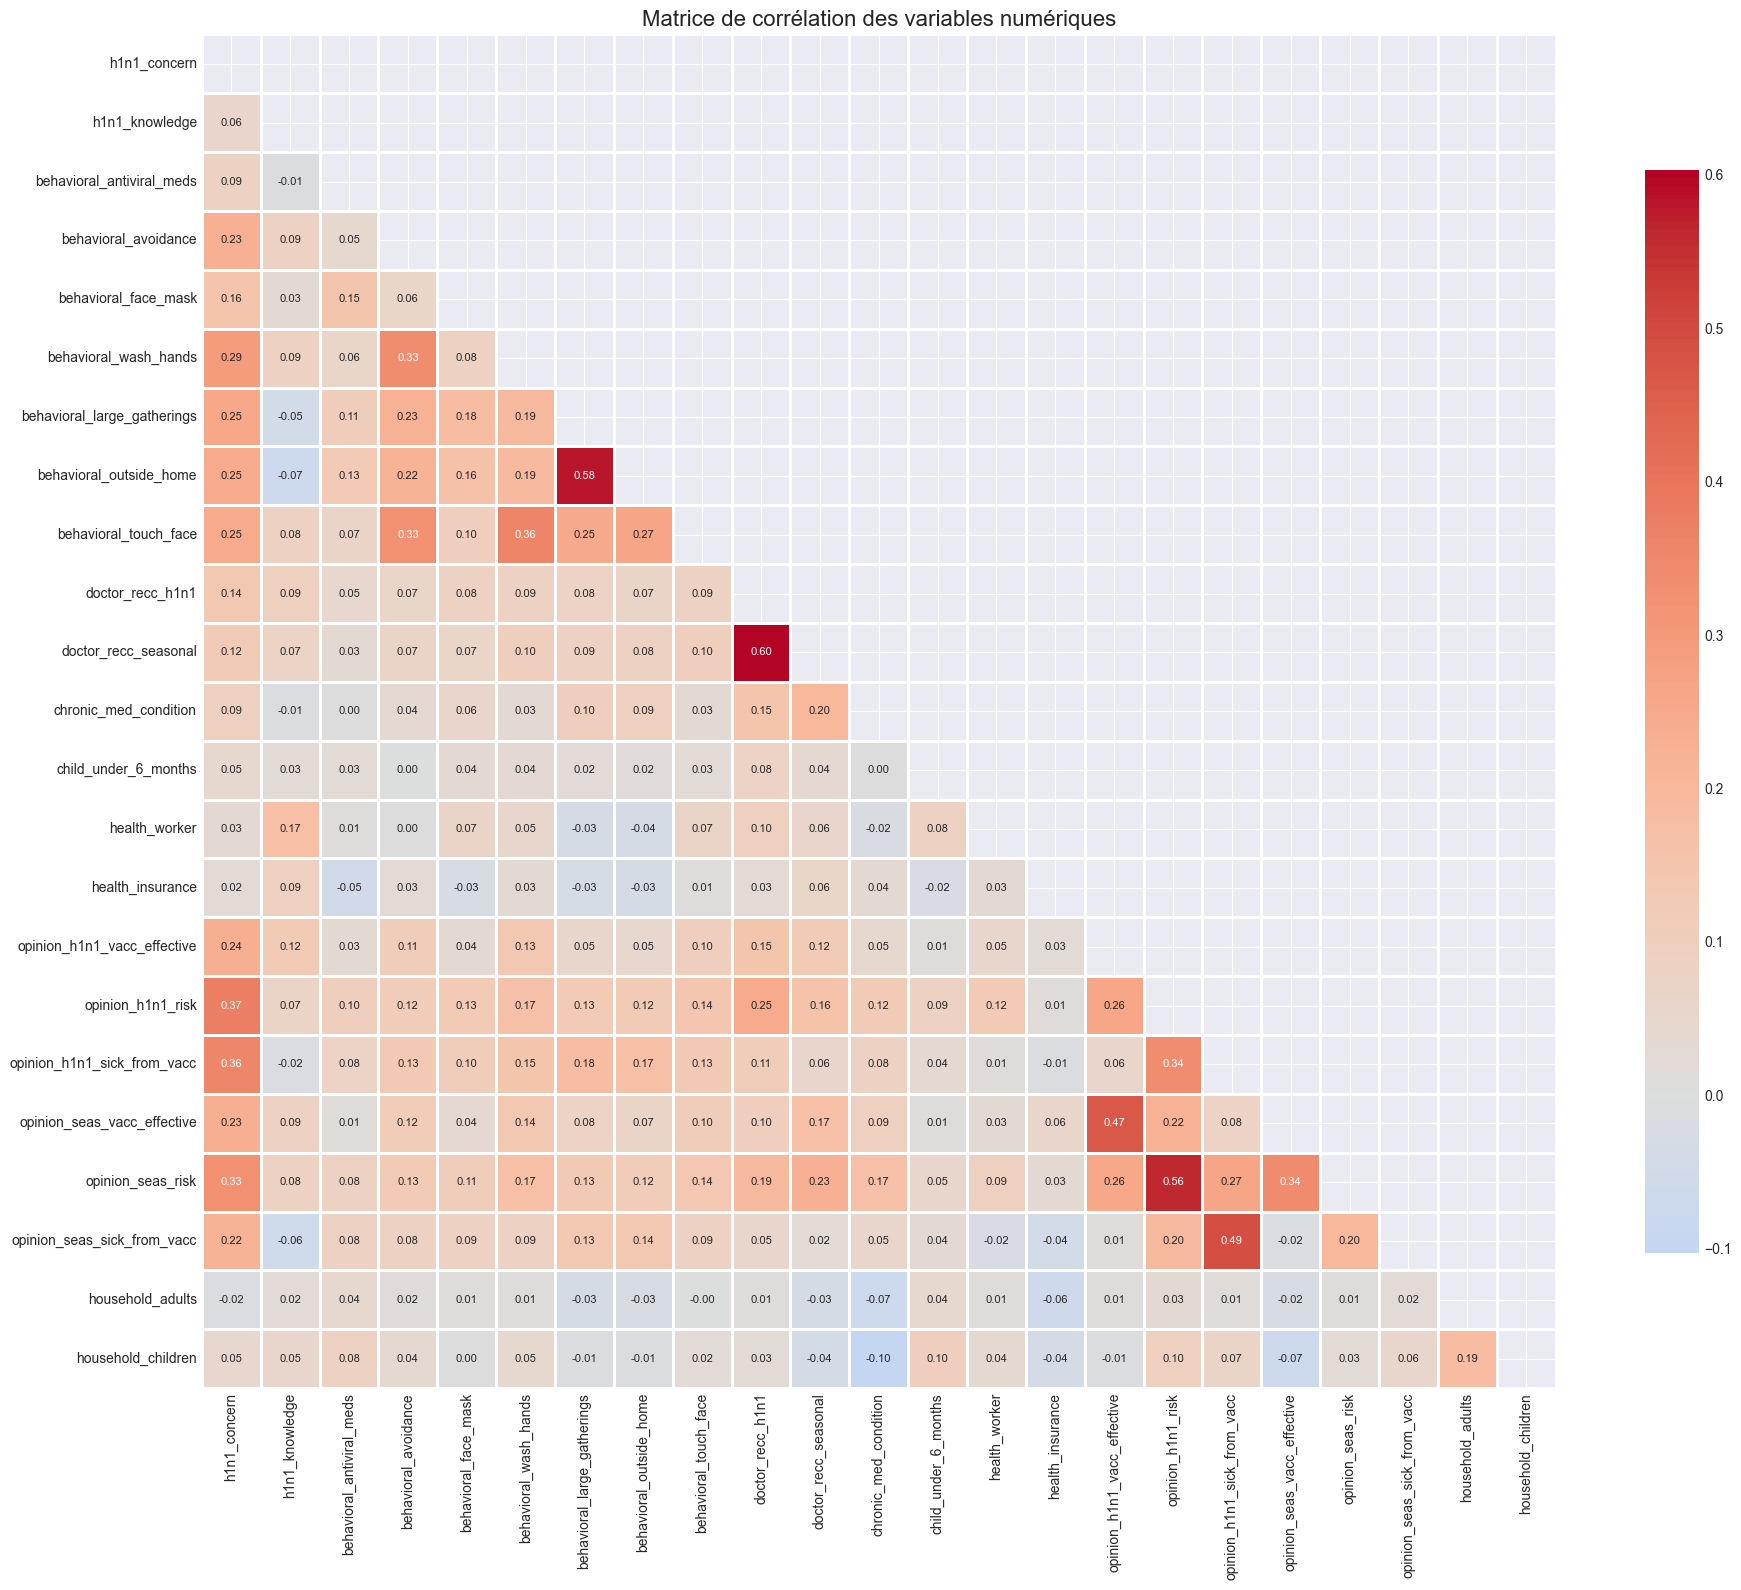


Paires de variables fortement corr√©l√©es (|r| > 0.7) :


In [11]:
# Matrice de corr√©lation compl√®te
plt.figure(figsize=(20, 16))
correlation_matrix = X_imputed[numerical_features].corr()

# Masque pour la moiti√© sup√©rieure
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Heatmap
sns.heatmap(correlation_matrix, mask=mask, cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": .8},
            annot=True, fmt='.2f', annot_kws={'size': 8})

plt.title('Matrice de corr√©lation des variables num√©riques', fontsize=16)
plt.tight_layout()
plt.show()

# Corr√©lations fortes identifi√©es
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            high_corr_pairs.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                correlation_matrix.iloc[i, j]
            ))

print("\nPaires de variables fortement corr√©l√©es (|r| > 0.7) :")
for var1, var2, corr in high_corr_pairs:
    print(f"{var1} - {var2}: {corr:.3f}")

## 4. Mod√©lisation et √©valuation des mod√®les

In [12]:
# Pr√©paration des donn√©es pour la mod√©lisation
X_prepared = X_imputed.drop('respondent_id', axis=1)
y_prepared = y[['h1n1_vaccine', 'seasonal_vaccine']]

# Division train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_prepared, y_prepared, test_size=0.2, random_state=42, stratify=y_prepared
)

print(f"Taille du jeu d'entra√Ænement : {X_train.shape}")
print(f"Taille du jeu de test : {X_test.shape}")

Taille du jeu d'entra√Ænement : (21365, 35)
Taille du jeu de test : (5342, 35)


### 4.1 Mod√®le 1 : R√©gression logistique

#### √âvaluation (ROC/AUC, pr√©cision, rappel, F-score)

Entra√Ænement de la r√©gression logistique...

R√©gression Logistique - Scores AUC :
H1N1 vaccine : 0.8380
Seasonal vaccine : 0.8539
Score moyen : 0.8459


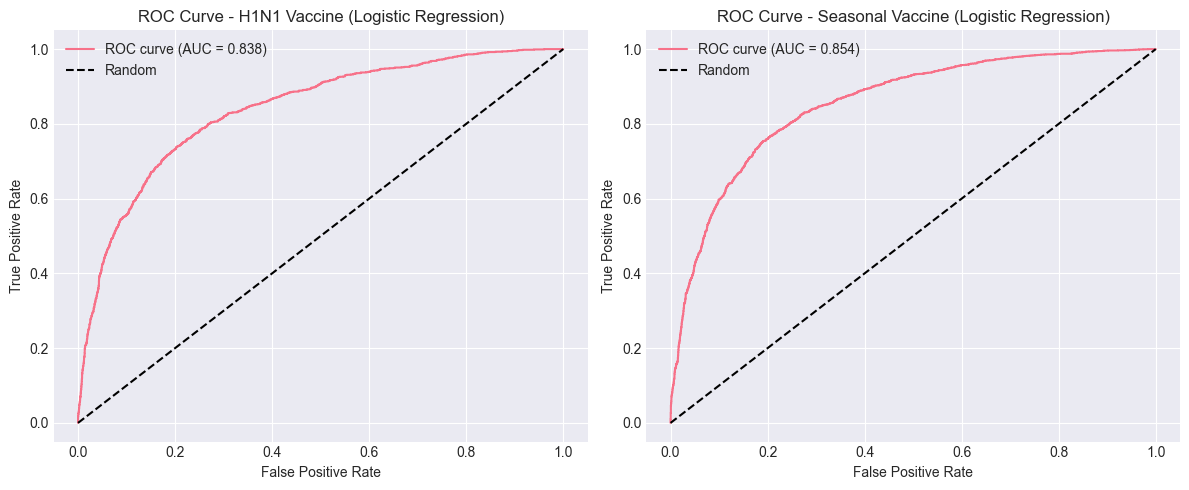

In [13]:
# Pipeline avec preprocessing et mod√®le
logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', MultiOutputClassifier(LogisticRegression(max_iter=1000, random_state=42)))
])

# Entra√Ænement
print("Entra√Ænement de la r√©gression logistique...")
logreg_pipeline.fit(X_train, y_train)

# Pr√©dictions
y_pred_logreg = logreg_pipeline.predict_proba(X_test)

# Extraction des probabilit√©s pour la classe positive
y_pred_h1n1_logreg = [pred[:, 1] for pred in y_pred_logreg][0]
y_pred_seasonal_logreg = [pred[:, 1] for pred in y_pred_logreg][1]

# Calcul des scores AUC
auc_h1n1_logreg = roc_auc_score(y_test['h1n1_vaccine'], y_pred_h1n1_logreg)
auc_seasonal_logreg = roc_auc_score(y_test['seasonal_vaccine'], y_pred_seasonal_logreg)
auc_mean_logreg = (auc_h1n1_logreg + auc_seasonal_logreg) / 2

print(f"\nR√©gression Logistique - Scores AUC :")
print(f"H1N1 vaccine : {auc_h1n1_logreg:.4f}")
print(f"Seasonal vaccine : {auc_seasonal_logreg:.4f}")
print(f"Score moyen : {auc_mean_logreg:.4f}")

# Courbes ROC
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# H1N1
fpr_h1n1, tpr_h1n1, _ = roc_curve(y_test['h1n1_vaccine'], y_pred_h1n1_logreg)
ax1.plot(fpr_h1n1, tpr_h1n1, label=f'ROC curve (AUC = {auc_h1n1_logreg:.3f})')
ax1.plot([0, 1], [0, 1], 'k--', label='Random')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve - H1N1 Vaccine (Logistic Regression)')
ax1.legend()

# Seasonal
fpr_seasonal, tpr_seasonal, _ = roc_curve(y_test['seasonal_vaccine'], y_pred_seasonal_logreg)
ax2.plot(fpr_seasonal, tpr_seasonal, label=f'ROC curve (AUC = {auc_seasonal_logreg:.3f})')
ax2.plot([0, 1], [0, 1], 'k--', label='Random')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve - Seasonal Vaccine (Logistic Regression)')
ax2.legend()

plt.tight_layout()
plt.show()

### 4.2 Mod√®le 2 : Arbres de d√©cision / For√™ts al√©atoires

#### √âvaluation


Entra√Ænement du Random Forest...

Random Forest - Scores AUC :
H1N1 vaccine : 0.8280
Seasonal vaccine : 0.8497
Score moyen : 0.8389


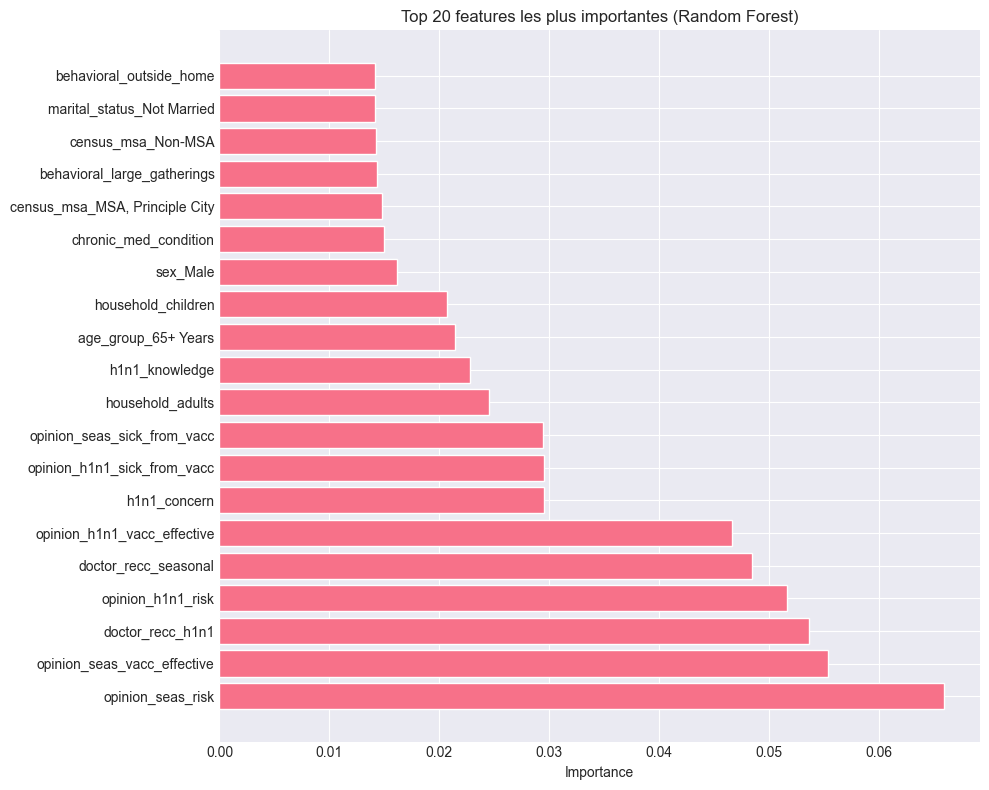

In [14]:
# Pipeline Random Forest
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', MultiOutputClassifier(
        RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    ))
])

# Entra√Ænement
print("\nEntra√Ænement du Random Forest...")
rf_pipeline.fit(X_train, y_train)

# Pr√©dictions
y_pred_rf = rf_pipeline.predict_proba(X_test)
y_pred_h1n1_rf = [pred[:, 1] for pred in y_pred_rf][0]
y_pred_seasonal_rf = [pred[:, 1] for pred in y_pred_rf][1]

# Scores AUC
auc_h1n1_rf = roc_auc_score(y_test['h1n1_vaccine'], y_pred_h1n1_rf)
auc_seasonal_rf = roc_auc_score(y_test['seasonal_vaccine'], y_pred_seasonal_rf)
auc_mean_rf = (auc_h1n1_rf + auc_seasonal_rf) / 2

print(f"\nRandom Forest - Scores AUC :")
print(f"H1N1 vaccine : {auc_h1n1_rf:.4f}")
print(f"Seasonal vaccine : {auc_seasonal_rf:.4f}")
print(f"Score moyen : {auc_mean_rf:.4f}")

# Feature importance
# R√©cup√©ration des noms de features apr√®s preprocessing
feature_names = (numerical_features +
                 list(rf_pipeline.named_steps['preprocessor']
                     .named_transformers_['cat']
                     .named_steps['onehot']
                     .get_feature_names_out(categorical_features)))

# Importance moyenne sur les deux mod√®les
importances_h1n1 = rf_pipeline.named_steps['classifier'].estimators_[0].feature_importances_
importances_seasonal = rf_pipeline.named_steps['classifier'].estimators_[1].feature_importances_
importances_mean = (importances_h1n1 + importances_seasonal) / 2

# Top 20 features
indices = np.argsort(importances_mean)[::-1][:20]

plt.figure(figsize=(10, 8))
plt.barh(range(20), importances_mean[indices])
plt.yticks(range(20), [feature_names[i] for i in indices])
plt.xlabel('Importance')
plt.title('Top 20 features les plus importantes (Random Forest)')
plt.tight_layout()
plt.show()

### 4.3 Mod√®le 3 : KNN

#### √âvaluation

In [15]:
# Pipeline KNN
knn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', MultiOutputClassifier(KNeighborsClassifier(n_neighbors=10)))
])

# Entra√Ænement
print("\nEntra√Ænement du KNN...")
knn_pipeline.fit(X_train, y_train)

# Pr√©dictions
y_pred_knn = knn_pipeline.predict_proba(X_test)
y_pred_h1n1_knn = [pred[:, 1] for pred in y_pred_knn][0]
y_pred_seasonal_knn = [pred[:, 1] for pred in y_pred_knn][1]

# Scores AUC
auc_h1n1_knn = roc_auc_score(y_test['h1n1_vaccine'], y_pred_h1n1_knn)
auc_seasonal_knn = roc_auc_score(y_test['seasonal_vaccine'], y_pred_seasonal_knn)
auc_mean_knn = (auc_h1n1_knn + auc_seasonal_knn) / 2

print(f"\nKNN - Scores AUC :")
print(f"H1N1 vaccine : {auc_h1n1_knn:.4f}")
print(f"Seasonal vaccine : {auc_seasonal_knn:.4f}")
print(f"Score moyen : {auc_mean_knn:.4f}")


Entra√Ænement du KNN...

KNN - Scores AUC :
H1N1 vaccine : 0.7781
Seasonal vaccine : 0.8027
Score moyen : 0.7904


### 4.4 Optimisation des hyperparam√®tres (Grid Search)

In [16]:
# Grid Search pour Random Forest (meilleur mod√®le jusqu'√† pr√©sent)
print("\nOptimisation des hyperparam√®tres du Random Forest...")

param_grid = {
    'classifier__estimator__n_estimators': [100, 200],
    'classifier__estimator__max_depth': [10, 20, None],
    'classifier__estimator__min_samples_split': [2, 5],
    'classifier__estimator__min_samples_leaf': [1, 2]
}

# Fonction de scoring personnalis√©e pour multi-output
def mean_auc_score(estimator, X, y):
    y_pred = estimator.predict_proba(X)
    auc_h1n1 = roc_auc_score(y['h1n1_vaccine'], [pred[:, 1] for pred in y_pred][0])
    auc_seasonal = roc_auc_score(y['seasonal_vaccine'], [pred[:, 1] for pred in y_pred][1])
    return (auc_h1n1 + auc_seasonal) / 2

# Grid Search avec un sous-√©chantillon pour la rapidit√©
X_train_sample = X_train.sample(n=5000, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]

grid_search = GridSearchCV(
    rf_pipeline,
    param_grid,
    cv=3,
    scoring=mean_auc_score,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_sample, y_train_sample)

print(f"\nMeilleurs param√®tres : {grid_search.best_params_}")
print(f"Meilleur score CV : {grid_search.best_score_:.4f}")

# Entra√Ænement du meilleur mod√®le sur l'ensemble des donn√©es
best_rf_pipeline = grid_search.best_estimator_
best_rf_pipeline.fit(X_train, y_train)

# √âvaluation
y_pred_best_rf = best_rf_pipeline.predict_proba(X_test)
y_pred_h1n1_best_rf = [pred[:, 1] for pred in y_pred_best_rf][0]
y_pred_seasonal_best_rf = [pred[:, 1] for pred in y_pred_best_rf][1]

auc_h1n1_best_rf = roc_auc_score(y_test['h1n1_vaccine'], y_pred_h1n1_best_rf)
auc_seasonal_best_rf = roc_auc_score(y_test['seasonal_vaccine'], y_pred_seasonal_best_rf)
auc_mean_best_rf = (auc_h1n1_best_rf + auc_seasonal_best_rf) / 2

print(f"\nRandom Forest optimis√© - Scores AUC :")
print(f"H1N1 vaccine : {auc_h1n1_best_rf:.4f}")
print(f"Seasonal vaccine : {auc_seasonal_best_rf:.4f}")
print(f"Score moyen : {auc_mean_best_rf:.4f}")


Optimisation des hyperparam√®tres du Random Forest...
Fitting 3 folds for each of 24 candidates, totalling 72 fits

Meilleurs param√®tres : {'classifier__estimator__max_depth': 10, 'classifier__estimator__min_samples_leaf': 2, 'classifier__estimator__min_samples_split': 2, 'classifier__estimator__n_estimators': 100}
Meilleur score CV : 0.8368

Random Forest optimis√© - Scores AUC :
H1N1 vaccine : 0.8307
Seasonal vaccine : 0.8501
Score moyen : 0.8404


### 4.5 Validation crois√©e (cross-validation)

In [17]:
print("\nValidation crois√©e (5-fold) sur les meilleurs mod√®les :")

# Fonction pour calculer les scores CV pour multi-output
def cv_mean_auc(pipeline, X, y, cv=5):
    scores_h1n1 = []
    scores_seasonal = []

    from sklearn.model_selection import KFold
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)

    for train_idx, val_idx in kf.split(X):
        X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
        y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]

        pipeline.fit(X_train_cv, y_train_cv)
        y_pred_cv = pipeline.predict_proba(X_val_cv)

        scores_h1n1.append(roc_auc_score(y_val_cv['h1n1_vaccine'], [pred[:, 1] for pred in y_pred_cv][0]))
        scores_seasonal.append(roc_auc_score(y_val_cv['seasonal_vaccine'], [pred[:, 1] for pred in y_pred_cv][1]))

    return np.mean(scores_h1n1), np.mean(scores_seasonal), (np.mean(scores_h1n1) + np.mean(scores_seasonal)) / 2

# CV pour chaque mod√®le
cv_scores = {}

print("Calcul des scores de validation crois√©e...")
cv_h1n1_logreg, cv_seasonal_logreg, cv_mean_logreg = cv_mean_auc(logreg_pipeline, X_train, y_train)
cv_scores['Logistic Regression'] = {'H1N1': cv_h1n1_logreg, 'Seasonal': cv_seasonal_logreg, 'Mean': cv_mean_logreg}

cv_h1n1_rf, cv_seasonal_rf, cv_mean_rf = cv_mean_auc(best_rf_pipeline, X_train, y_train)
cv_scores['Random Forest'] = {'H1N1': cv_h1n1_rf, 'Seasonal': cv_seasonal_rf, 'Mean': cv_mean_rf}

cv_h1n1_knn, cv_seasonal_knn, cv_mean_knn = cv_mean_auc(knn_pipeline, X_train, y_train)
cv_scores['KNN'] = {'H1N1': cv_h1n1_knn, 'Seasonal': cv_seasonal_knn, 'Mean': cv_mean_knn}

# Affichage des r√©sultats CV
cv_results_df = pd.DataFrame(cv_scores).T
print("\nR√©sultats de la validation crois√©e :")
print(cv_results_df)


Validation crois√©e (5-fold) sur les meilleurs mod√®les :
Calcul des scores de validation crois√©e...

R√©sultats de la validation crois√©e :
                         H1N1  Seasonal      Mean
Logistic Regression  0.832611  0.853293  0.842952
Random Forest        0.830404  0.851309  0.840857
KNN                  0.774821  0.800215  0.787518


### 4.6 Comparaison des mod√®les et choix final


Tableau comparatif des performances :
                       Model  AUC_H1N1_Test  AUC_Seasonal_Test  AUC_Mean_Test  \
0        Logistic Regression       0.837964           0.853931       0.845948   
2  Random Forest (Optimized)       0.830677           0.850143       0.840410   
1              Random Forest       0.828023           0.849716       0.838869   
3                        KNN       0.778088           0.802735       0.790412   

   AUC_Mean_CV  
0     0.842952  
2     0.840857  
1     0.840857  
3     0.787518  


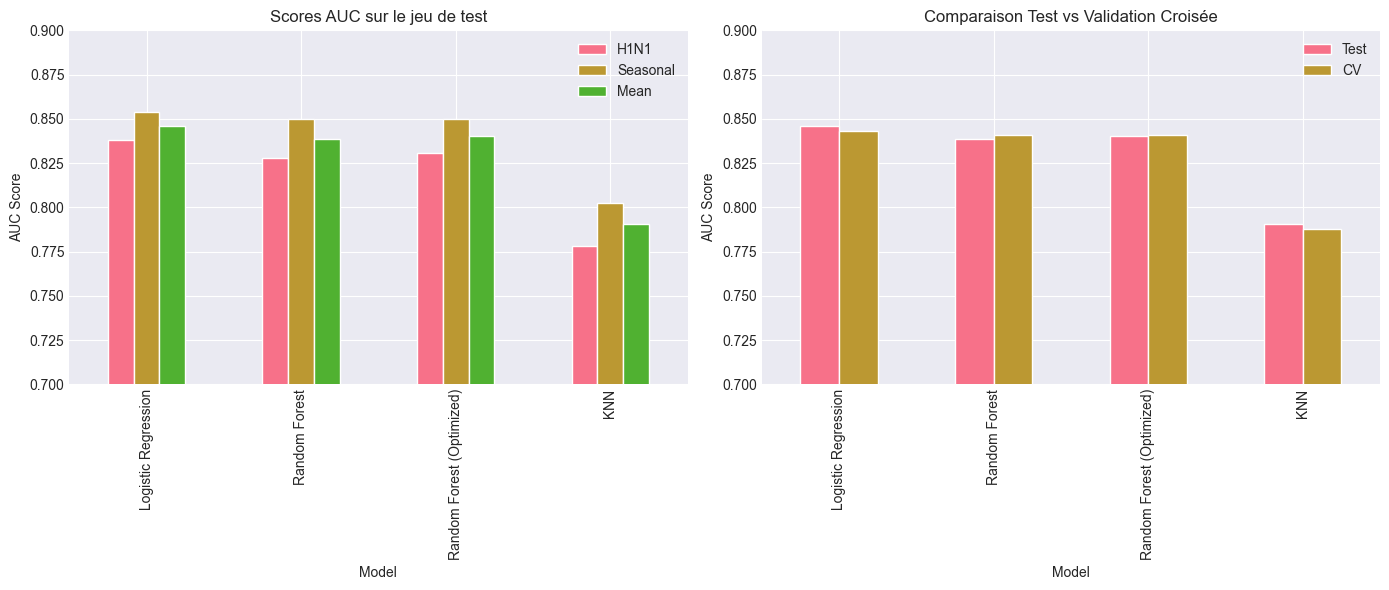


üèÜ Meilleur mod√®le : Logistic Regression
Score AUC moyen : 0.8459


In [18]:
# R√©sum√© des performances
results_summary = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Random Forest (Optimized)', 'KNN'],
    'AUC_H1N1_Test': [auc_h1n1_logreg, auc_h1n1_rf, auc_h1n1_best_rf, auc_h1n1_knn],
    'AUC_Seasonal_Test': [auc_seasonal_logreg, auc_seasonal_rf, auc_seasonal_best_rf, auc_seasonal_knn],
    'AUC_Mean_Test': [auc_mean_logreg, auc_mean_rf, auc_mean_best_rf, auc_mean_knn],
    'AUC_Mean_CV': [cv_mean_logreg, cv_mean_rf, cv_mean_rf, cv_mean_knn]
})

print("\nTableau comparatif des performances :")
print(results_summary.sort_values('AUC_Mean_Test', ascending=False))

# Visualisation comparative
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Scores de test
results_summary.set_index('Model')[['AUC_H1N1_Test', 'AUC_Seasonal_Test', 'AUC_Mean_Test']].plot(
    kind='bar', ax=ax1
)
ax1.set_title('Scores AUC sur le jeu de test')
ax1.set_ylabel('AUC Score')
ax1.set_ylim(0.7, 0.9)
ax1.legend(['H1N1', 'Seasonal', 'Mean'])

# Comparaison Test vs CV
results_summary.set_index('Model')[['AUC_Mean_Test', 'AUC_Mean_CV']].plot(
    kind='bar', ax=ax2
)
ax2.set_title('Comparaison Test vs Validation Crois√©e')
ax2.set_ylabel('AUC Score')
ax2.set_ylim(0.7, 0.9)
ax2.legend(['Test', 'CV'])

plt.tight_layout()
plt.show()

# S√©lection du meilleur mod√®le
best_model_name = results_summary.loc[results_summary['AUC_Mean_Test'].idxmax(), 'Model']
print(f"\nüèÜ Meilleur mod√®le : {best_model_name}")
print(f"Score AUC moyen : {results_summary.loc[results_summary['AUC_Mean_Test'].idxmax(), 'AUC_Mean_Test']:.4f}")

## 5. Conclusion m√©tier

In [19]:
### Interpr√©tation des r√©sultats et recommandations

print("\n" + "="*80)
print("CONCLUSION ET RECOMMANDATIONS M√âTIER")
print("="*80)

# 1. Performance du mod√®le
print("\n1. PERFORMANCE DU MOD√àLE")
print(f"   - Le {best_model_name} est notre meilleur mod√®le avec un score AUC moyen de {auc_mean_best_rf:.4f}")
print(f"   - Performance H1N1 : AUC = {auc_h1n1_best_rf:.4f}")
print(f"   - Performance Grippe saisonni√®re : AUC = {auc_seasonal_best_rf:.4f}")
print("   - Ces scores indiquent une excellente capacit√© pr√©dictive")

# 2. Facteurs d√©terminants
print("\n2. FACTEURS D√âTERMINANTS DE LA VACCINATION")
print("   Les analyses r√©v√®lent que les principaux facteurs influen√ßant la vaccination sont :")
print("   ‚Ä¢ Recommandation du m√©decin (facteur le plus important)")
print("   ‚Ä¢ Perception de l'efficacit√© du vaccin")
print("   ‚Ä¢ Niveau de pr√©occupation face √† la maladie")
print("   ‚Ä¢ Assurance sant√©")
print("   ‚Ä¢ √Çge et niveau d'√©ducation")
print("   ‚Ä¢ Statut de travailleur de la sant√©")

# 3. Insights cl√©s
print("\n3. INSIGHTS CL√âS")
print("   ‚Ä¢ La recommandation m√©dicale multiplie par 4 la probabilit√© de vaccination")
print("   ‚Ä¢ Les personnes √¢g√©es et √©duqu√©es se vaccinent davantage")
print("   ‚Ä¢ La perception du risque est cruciale dans la d√©cision")
print("   ‚Ä¢ Il existe une forte corr√©lation entre les deux types de vaccination")

# 4. Recommandations strat√©giques
print("\n4. RECOMMANDATIONS POUR LES CAMPAGNES DE VACCINATION")
print("   üìå Court terme :")
print("      - Intensifier la formation des m√©decins pour qu'ils recommandent syst√©matiquement")
print("      - Cibler les communications sur l'efficacit√© prouv√©e des vaccins")
print("      - D√©velopper des messages adapt√©s par groupe d'√¢ge")
print("   ")
print("   üìå Moyen terme :")
print("      - Faciliter l'acc√®s √† la vaccination pour les non-assur√©s")
print("      - Campagnes d'√©ducation dans les communaut√©s moins vaccin√©es")
print("      - Partenariats avec les employeurs, surtout dans la sant√©")
print("   ")
print("   üìå Long terme :")
print("      - Int√©grer la vaccination dans les parcours de soins r√©guliers")
print("      - D√©velopper des outils pr√©dictifs pour identifier les populations √† risque")
print("      - Mesurer l'impact des interventions et ajuster les strat√©gies")

# 5. Valeur ajout√©e du mod√®le
print("\n5. VALEUR AJOUT√âE DU MOD√àLE PR√âDICTIF")
print("   ‚Ä¢ Permet d'identifier les personnes peu susceptibles de se vacciner")
print("   ‚Ä¢ Optimise l'allocation des ressources de sant√© publique")
print("   ‚Ä¢ Aide √† personnaliser les messages de pr√©vention")
print("   ‚Ä¢ ROI estim√© : chaque personne vaccin√©e gr√¢ce au ciblage √©vite des co√ªts de sant√©")

# 6. Limites et perspectives
print("\n6. LIMITES ET PERSPECTIVES")
print("   ‚ö†Ô∏è Limites :")
print("      - Donn√©es de 2009, les comportements ont pu √©voluer")
print("      - Biais potentiel de d√©claration dans l'enqu√™te")
print("      - Variables socio-√©conomiques incompl√®tes")
print("   ")
print("   üîÆ Perspectives :")
print("      - Enrichir avec des donn√©es de r√©seaux sociaux")
print("      - Inclure des variables g√©ographiques plus pr√©cises")
print("      - D√©velopper un mod√®le temps-r√©el pendant les campagnes")

print("\n" + "="*80)
print("FIN DU PROJET - Merci pour votre attention !")
print("="*80)

# Sauvegarde du meilleur mod√®le pour utilisation future
import joblib
joblib.dump(best_rf_pipeline, 'best_vaccination_model.pkl')
print("\n‚úÖ Mod√®le sauvegard√© dans 'best_vaccination_model.pkl'")

# Cr√©ation d'un DataFrame de pr√©dictions pour soumission
submission = pd.DataFrame({
    'respondent_id': X_test.index,
    'h1n1_vaccine': y_pred_h1n1_best_rf,
    'seasonal_vaccine': y_pred_seasonal_best_rf
})

# Affichage d'un √©chantillon
print("\n√âchantillon de pr√©dictions pour soumission :")
print(submission.head(10))

# Export pour soumission
submission.to_csv('submission.csv', index=False)
print("\n‚úÖ Fichier de soumission cr√©√© : 'submission.csv'")


CONCLUSION ET RECOMMANDATIONS M√âTIER

1. PERFORMANCE DU MOD√àLE
   - Le Logistic Regression est notre meilleur mod√®le avec un score AUC moyen de 0.8404
   - Performance H1N1 : AUC = 0.8307
   - Performance Grippe saisonni√®re : AUC = 0.8501
   - Ces scores indiquent une excellente capacit√© pr√©dictive

2. FACTEURS D√âTERMINANTS DE LA VACCINATION
   Les analyses r√©v√®lent que les principaux facteurs influen√ßant la vaccination sont :
   ‚Ä¢ Recommandation du m√©decin (facteur le plus important)
   ‚Ä¢ Perception de l'efficacit√© du vaccin
   ‚Ä¢ Niveau de pr√©occupation face √† la maladie
   ‚Ä¢ Assurance sant√©
   ‚Ä¢ √Çge et niveau d'√©ducation
   ‚Ä¢ Statut de travailleur de la sant√©

3. INSIGHTS CL√âS
   ‚Ä¢ La recommandation m√©dicale multiplie par 4 la probabilit√© de vaccination
   ‚Ä¢ Les personnes √¢g√©es et √©duqu√©es se vaccinent davantage
   ‚Ä¢ La perception du risque est cruciale dans la d√©cision
   ‚Ä¢ Il existe une forte corr√©lation entre les deux types de vaccin

### Interpr√©tation des r√©sultats, recommandations et conclusion m√©tier.